In [1]:
!pip install fastcore fastai2 nbdev -q

     |████████████████████████████████| 194kB 4.3MB/s 
     |████████████████████████████████| 51kB 6.3MB/s 


# Imports

In [0]:
from fastai2.text.all import *
from fastai2.tabular.all import *
import pandas as pd

from pathlib import Path

In [0]:
#DATA='./Rakuten/dataset'
#FILENAME='df_all.csv'
FILENAME='df_sample.csv'

# Loading Data

In [0]:
Path(f'{DATA}/{FILENAME}').exists()

True

In [0]:
df = pd.read_csv(Path(f'{DATA}/{FILENAME}'))

In [0]:
len(df),list(df.columns.values)

(84916,
 ['Title',
  'Description',
  'Image_id',
  'Product_id',
  'Prdtypecode',
  'Prdlbl',
  'image_path'])

In [0]:
df.sample(n=3)

,Title,Description,Image_id,Product_id,Prdtypecode,Prdlbl,image_path
35176,Voyant de contrôle pour lavage Ø75 - pn 10b,Voyant de turbidité pour circuit de filtration...,1249535608,3819982827,2583,Household,Rakuten/dataset/image/image_training/image_124...
69964,Les Sims 2 - Kit Demeures De Rêve,NaN,874731567,73872464,40,Entertainment,Rakuten/dataset/image/image_training/image_874...
5292,Guide chaine pour Elagueur Florabest,Guide chaine compatible avec appareils Fahe18b...,1322677121,4230268477,2585,Household,Rakuten/dataset/image/image_training/image_132...


In [0]:
df['Description'].fillna(' ', inplace=True)

In [0]:
df.sample(n=3)

,Title,Description,Image_id,Product_id,Prdtypecode,Prdlbl,image_path
60345,Éclairage de plafond de lecture de plate-forme de cuisine de la CE de CREE LED de 3W 12V 24V,,1299051705,4139887569,2583,Household,Rakuten/dataset/image/image_training/image_1299051705_product_4139887569.jpg
27463,Décoration Du Foyer Coussin Graffi Style Throw Couvertures Taie D'oreiller Suan18351,,1273470931,3992734329,1920,Household,Rakuten/dataset/image/image_training/image_1273470931_product_3992734329.jpg
44573,Micro Usb De Charge Avec Indicateur De Charge Mise Au Point Réglable En Alliage D'aluminium Led Stream,,1324149347,4236042852,1302,Child,Rakuten/dataset/image/image_training/image_1324149347_product_4236042852.jpg


In [0]:
df.Prdtypecode.nunique()

27

In [0]:
df['Title'] = df['Title'].astype(str)
df['Description'] = df['Description'].astype(str)
df['Prdtypecode'] = df['Prdtypecode'].astype('category') 

In [0]:
df.dtypes

Title            object
Description      object
Image_id          int64
Product_id        int64
Prdtypecode    category
Prdlbl           object
image_path       object
dtype: object

In [0]:
prod_sample = df.sample(frac=0.20)

In [0]:
len(prod_sample), prod_sample.Prdtypecode.nunique()

(16983, 27)

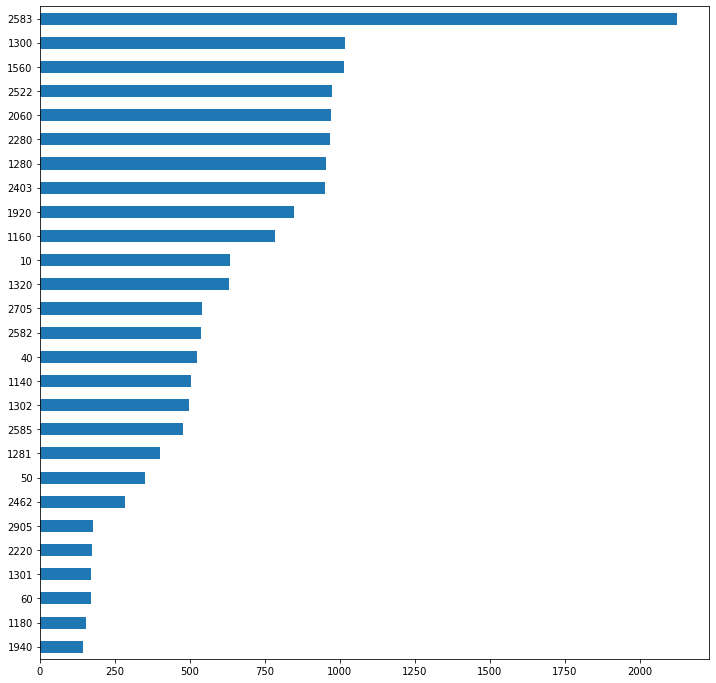

In [0]:
prod_sample.Prdtypecode.value_counts(ascending=True).plot.barh(figsize=(12,12))

# DataBlock

In [0]:
import pandas as pd
prod_sample= pd.read_csv('df_sample.csv')

## Language Model

In [0]:
txt_blk_lm = TextBlock.from_df(text_cols=['Title', 'Description'], 
                               is_lm=True, 
                               seq_len=72,                                 
                               tok_func=SpacyTokenizer, 
                               lang='fr', 
                               res_col_name='text')

In [0]:
db_lm = DataBlock(blocks=txt_blk_lm, 
                  get_x=ColReader('text'), 
                  splitter=RandomSplitter(valid_pct=0.1, seed=42))

In [13]:
dls_lm = db_lm.dataloaders(prod_sample, bs=64, seq_len=72)

In [8]:
b = dls_lm.one_batch(); len(b), len(b[0]), len(b[1]), b[0].shape, b[1].shape

(2, 64, 64, torch.Size([64, 72]), torch.Size([64, 72]))

In [14]:
dls_lm.show_batch()

,text,text_
0,xxbos xxfld 1 doauhao ® xxunk xxmaj jouets électriques xxmaj capteur xxmaj infrarouge xxmaj xxunk xxmaj xxunk xxfld 2 xxbos xxfld 1 xxmaj motif de xxunk pliant à main xxmaj xxunk xxmaj fan brodé xxmaj sequin de soirée de mariage b xxfld 2 xxbos xxfld 1 xxmaj brass xxmaj xxunk xxmaj xxunk xxmaj axle xxmaj balance xxmaj poids xxmaj pour 1 / 10 xxmaj rc xxmaj traxxas xxmaj trx4 xxunk xxfld 2,xxfld 1 doauhao ® xxunk xxmaj jouets électriques xxmaj capteur xxmaj infrarouge xxmaj xxunk xxmaj xxunk xxfld 2 xxbos xxfld 1 xxmaj motif de xxunk pliant à main xxmaj xxunk xxmaj fan brodé xxmaj sequin de soirée de mariage b xxfld 2 xxbos xxfld 1 xxmaj brass xxmaj xxunk xxmaj xxunk xxmaj axle xxmaj balance xxmaj poids xxmaj pour 1 / 10 xxmaj rc xxmaj traxxas xxmaj trx4 xxunk xxfld 2 xxbos
1,kangourou xxmaj zipper xxmaj hoodie xxmaj taille : xxmaj xxl xxmaj poitrine : 110 - 116 cm 91 - 95 cm xxmaj xxunk : 116 - 123 cm xxmaj clair + xxfld 2 xxbos xxfld 1 6pcs xxunk - pièces xxmaj motif xxmaj dinosaure + xxmaj rouleau à xxmaj pâtisserie xxmaj en xxmaj bois xxmaj pour xxmaj décoration xxmaj pâte à xxmaj sucre xxmaj xxunk xxmaj gâteau xxmaj magideal xxfld 2 xxbos,xxmaj zipper xxmaj hoodie xxmaj taille : xxmaj xxl xxmaj poitrine : 110 - 116 cm 91 - 95 cm xxmaj xxunk : 116 - 123 cm xxmaj clair + xxfld 2 xxbos xxfld 1 6pcs xxunk - pièces xxmaj motif xxmaj dinosaure + xxmaj rouleau à xxmaj pâtisserie xxmaj en xxmaj bois xxmaj pour xxmaj décoration xxmaj pâte à xxmaj sucre xxmaj xxunk xxmaj gâteau xxmaj magideal xxfld 2 xxbos xxfld
2,d' xxunk xxmaj et xxmaj xxunk xxfld 2 xxbos xxfld 1 xxmaj les xxmaj coups xxmaj xxunk xxmaj de xxup m. xxmaj de xxmaj la xxmaj xxunk xxfld 2 xxbos xxfld 1 xxmaj assiette anti-dérapante xxmaj pêche - xxmaj babymoov xxfld 2 xxbos xxfld 1 xxmaj jeu xxmaj xbox 360 xxmaj halo xxmaj wars + xxmaj halo 3 xxfld 2 xxbos xxfld 1 xxmaj piscine tubulaire xxmaj rectangulaire xxmaj splash - xxunk,xxunk xxmaj et xxmaj xxunk xxfld 2 xxbos xxfld 1 xxmaj les xxmaj coups xxmaj xxunk xxmaj de xxup m. xxmaj de xxmaj la xxmaj xxunk xxfld 2 xxbos xxfld 1 xxmaj assiette anti-dérapante xxmaj pêche - xxmaj babymoov xxfld 2 xxbos xxfld 1 xxmaj jeu xxmaj xbox 360 xxmaj halo xxmaj wars + xxmaj halo 3 xxfld 2 xxbos xxfld 1 xxmaj piscine tubulaire xxmaj rectangulaire xxmaj splash - xxunk x
3,en xxmaj plastique xxfld 2 xxbos xxfld 1 xxmaj joyeux xxmaj noël xxmaj oreiller xxmaj entoilées xxmaj coussin xxmaj sofa xxmaj home xxmaj décor xxmaj oreiller xxmaj de xxmaj base xxfld 2 xxbos xxfld 1 xxmaj thermomètre xxmaj de xxmaj bain xxmaj electronique xxmaj poisson xxmaj vert xxfld 2 xxbos xxfld 1 xxmaj lame d' eau rectangulaire à xxup led 90 cm en acier inoxydable pour piscine xxfld 2 xxbos xxfld 1,xxmaj plastique xxfld 2 xxbos xxfld 1 xxmaj joyeux xxmaj noël xxmaj oreiller xxmaj entoilées xxmaj coussin xxmaj sofa xxmaj home xxmaj décor xxmaj oreiller xxmaj de xxmaj base xxfld 2 xxbos xxfld 1 xxmaj thermomètre xxmaj de xxmaj bain xxmaj electronique xxmaj poisson xxmaj vert xxfld 2 xxbos xxfld 1 xxmaj lame d' eau rectangulaire à xxup led 90 cm en acier inoxydable pour piscine xxfld 2 xxbos xxfld 1 xxmaj
4,xxmaj usb xxmaj pour xxmaj game xxmaj cube xxmaj controller xxmaj adapter xxmaj xxunk xxfld 2 xxbos xxfld 1 xxmaj carnet xxmaj de xxmaj notes bloc - notes xxmaj cahier xxmaj coucher xxmaj de xxmaj soleil xxmaj tout xxmaj le xxmaj long xxmaj de xxmaj la xxmaj route xxmaj de xxmaj la xxmaj soie xxmaj xxunk xxmaj xxunk xxmaj carnet xxmaj de xxmaj journal xxmaj journal xxup a5 xxmaj de xxmaj la,usb xxmaj pour xxmaj game xxmaj cube xxmaj controller xxmaj adapter xxmaj xxunk xxfld 2 xxbos xxfld 1 xxmaj carnet xxmaj de xxmaj notes bloc - notes xxmaj cahier xxmaj coucher xxmaj de xxmaj soleil xxmaj tout xxmaj le xxmaj long xxmaj de xxmaj la xxmaj route xxmaj de xxmaj la xxmaj soie xxmaj xxunk xxmaj xxunk xxmaj carnet xxmaj de xxmaj journal xxmaj journal xxup a5 xxmaj de xxmaj la xxmaj
5,xxunk - xxmaj terry xxmaj in xxmaj xxunk - xxmaj funko xxmaj pop xxu

In [15]:
len(dls_lm.vocab)

7920

## Classification

In [0]:
txt_blk_cls = TextBlock.from_df(text_cols=['Title', 'Description'],
                                vocab=dls_lm.vocab,
                                is_lm=False, 
                                seq_len=72,                                 
                                tok_func=SpacyTokenizer, 
                                lang='fr', 
                                res_col_name='text')

In [0]:
db_cls = DataBlock(blocks=(txt_blk_cls,CategoryBlock),                  
                   get_x=ColReader('text'),
                   get_y=ColReader('Prdtypecode'),
                   splitter=RandomSplitter(valid_pct=0.15, seed=42))

In [18]:
db_cls.summary(prod_sample)

Setting-up type transforms pipelines
0                     Remplacement Bracelet En Cuir De Luxe Bracelet Bracelet Pour Fitbit Charge 2 Bk Stream  ...  Rakuten/dataset/image/image_training/image_1324199486_product_4236297869.jpg
1                                           Geometric Pillow Case Waist Cushion Cover Sofa Home Decor Cc3668  ...  Rakuten/dataset/image/image_training/image_1275151361_product_4004088812.jpg
2                       Simple Linen Creative Belle Oreiller Taie D'oreiller Taie D'oreiller Car Cover Cc400  ...  Rakuten/dataset/image/image_training/image_1275050731_product_4004067981.jpg
3                                       The Uncanny X-Men (Marvel Comics) - #296-297-298-299-300 - Comics Vo  ...  Rakuten/dataset/image/image_training/image_1150001483_product_2567988729.jpg
4      3pcs Non-Slip De Bain Tapis De Bain Tapis Cuisine Paillassons Décor Accessoires De Salle De Bain 1920  ...  Rakuten/dataset/image/image_training/image_1317085608_product_4211268511.jpg
...

Setting up Pipeline: ColReader -> Categorize

Building one sample
  Pipeline: ColReader -> Tokenizer -> Numericalize
    starting from
      Image_id                                                                                                                                                                                                                    1273141786
Product_id                                                                                                                                                                                                                  3993164358
Prdtypecode                                                                                                                                                                                                                       1560
Prdlbl                                                                                                                                                                

Setting up after_item: Pipeline: ToTensor
Setting up before_batch: Pipeline: partial
Setting up after_batch: Pipeline: 

Building one batch
Applying item_tfms to the first sample:
  Pipeline: ToTensor
    starting from
      (TensorText of size 30, TensorCategory(13))
    applying ToTensor gives
      (TensorText of size 30, TensorCategory(13))

Adding the next 3 samples

Applying before_batch to the list of samples
  Pipeline: partial
    starting from
      [(TensorText of size 30, TensorCategory(13)), (TensorText of size 27, TensorCategory(14)), (TensorText([   2,    4,    9,    8,   97,    8,  838,   16,    8, 3021,    8,   14,
           8, 1393,  815,    8,   21,  168,    4,   10]), TensorCategory(17)), (TensorText of size 29, TensorCategory(13))]
    applying partial gives
      [(TensorText of size 30, TensorCategory(13)), (TensorText of size 30, TensorCategory(14)), (TensorText of size 30, TensorCategory(17)), (TensorText of size 30, TensorCategory(13))]

Collating items in a 

In [20]:
dls_cls = db_cls.dataloaders(prod_sample, bs=64, seq_len=72)

# Language Model

In [22]:
learn_lm = language_model_learner(dls=dls_lm,
                                  arch=AWD_LSTM,
                                  metrics=[accuracy, Perplexity()])

SuggestedLRs(lr_min=0.15848932266235352, lr_steep=0.0831763744354248)

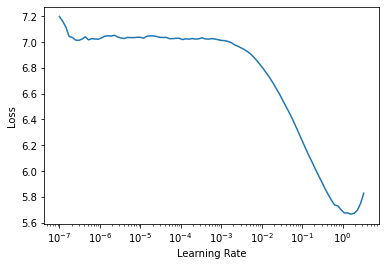

In [23]:
learn_lm.lr_find()

In [24]:
learn_lm.fine_tune(2,base_lr=8e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.685881,2.875468,0.563765,17.733730,00:26


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.665703,2.498182,0.592255,12.160364,00:29
1,2.379131,2.392517,0.602892,10.940993,00:28


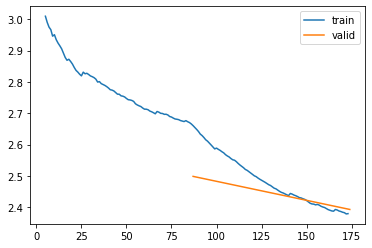

In [25]:
learn_lm.recorder.plot_loss()

In [0]:
learn_lm.save_encoder('fine_tuned_enc_2ep_8e_2lr')

# Classification

In [37]:
dls_cls.train_ds.vocab

(#2) [['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld', 'xxrep', 'xxwrep', 'xxup', 'xxmaj', '1', '2', '-', 'de', '/', 'pour', 'en', 'à', 'la', "d'", 'et', '(', 'cm', ')', 'x', '+', 'du', '3', ':', 'le', 'piscine', 'jeu', 'les', '.', 'n°', 'm', 'lot', 'avec', "l'", 'coussin', '4', 'des', '"', 'kit', 'enfants', 'rc', 'taie', 'blanc', 'a', 'oreiller', 'mm', 'the', '&', '10', 'bébé', 'bois', 'led', 'sac', 'g', 'décor', '6', '5', 'noir', 'home', 'bleu', 'décoration', 'noël', 'drone', 'notes', 'carte', 'jeux', 'bâche', 'of', 'mini', '°', 'n', 'canapé', 'portable', 'journal', 'acier', 'couverture', '8', 'par', 'au', 'générique', '12', 'voiture', 'console', '0', 'dji', 'spa', 'magideal', 'cadeau', 'l', 'jardin', 'set', 'gris', 'cuisine', 'lampe', 'sur', 'jouet', 'h', 'figurine', 'pompe', 'coton', 'housse', 'carnet', 'tapis', ']', 'table', 'bulles', '…', 'rouge', 'lit', 'tissu', '7', 'jouets', 's', '®', 'classique', '!', 'intex', 'collection', 'un', '[', 'nouveau', '100', 'ronde', 'for', 'support',

In [33]:
dls_cls.train.categorize.vocab

(#27) [10,40,50,60,1140,1160,1180,1280,1281,1300...]

In [0]:
del learn_cls

In [0]:
learn_cls = text_classifier_learner(dls=dls_cls,
                                    arch=AWD_LSTM,
                                    metrics=[accuracy, error_rate])

In [0]:
learn_cls = learn_cls.load_encoder('fine_tuned_enc_2ep_8e_2lr')

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.03981071710586548)

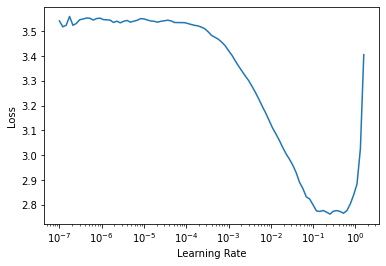

In [40]:
learn_cls.lr_find()

In [51]:
learn_cls.fit_one_cycle(5, lr_max=4e-2)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.548599,1.233416,0.636828,0.363172,00:22
1,1.426484,1.108948,0.660777,0.339223,00:22
2,1.389573,1.065475,0.678838,0.321162,00:22
3,1.232132,1.012459,0.696506,0.303494,00:22
4,1.192282,0.979193,0.697291,0.302709,00:22


SuggestedLRs(lr_min=0.0006309573538601399, lr_steep=2.75422871709452e-06)

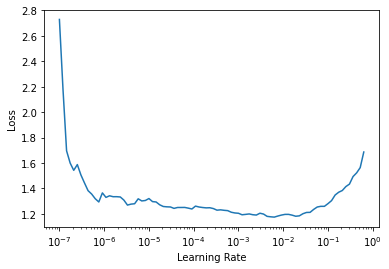

In [53]:
learn_cls.freeze_to(-2)
learn_cls.lr_find()

In [54]:
learn_cls.fit_one_cycle(5, lr_max=slice(5e-3/(2.6**4), 5e-3))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.116148,0.972782,0.698076,0.301924,00:22
1,1.027064,0.924160,0.712996,0.287004,00:22
2,0.948409,0.872834,0.732627,0.267373,00:22
3,0.850732,0.850015,0.734197,0.265803,00:22
4,0.818706,0.845078,0.738516,0.261484,00:22


SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=1.0964781722577754e-06)

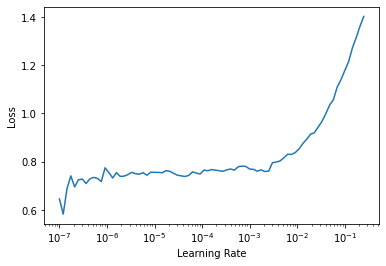

In [55]:
learn_cls.freeze_to(-3)
learn_cls.lr_find()

In [56]:
learn_cls.fit_one_cycle(5, lr_max=slice(5e-4/(2.6**4), 5e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.792916,0.846726,0.738123,0.261877,00:22
1,0.837714,0.821554,0.747546,0.252454,00:23
2,0.793870,0.818904,0.745583,0.254417,00:22
3,0.759668,0.814422,0.744405,0.255595,00:22
4,0.767147,0.813599,0.747546,0.252454,00:22


In [0]:
learn_cls.unfreeze()

SuggestedLRs(lr_min=3.311311274956097e-07, lr_steep=7.585775847473997e-07)

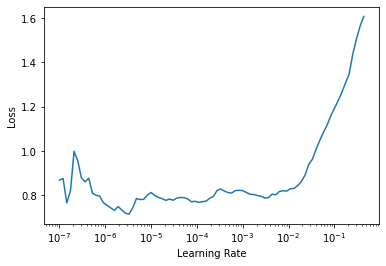

In [58]:
learn_cls.lr_find()

In [59]:
learn_cls.fit_one_cycle(4, lr_max=slice(5e-3/(2.6**4), 5e-3))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.811842,0.805993,0.756184,0.243816,00:24
1,0.711726,0.784311,0.756576,0.243424,00:24
2,0.584791,0.768937,0.768355,0.231645,00:23
3,0.502658,0.757346,0.769140,0.230860,00:23


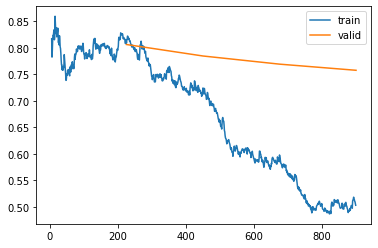

In [60]:
learn_cls.recorder.plot_loss()

In [61]:
inter = ClassificationInterpretation.from_learner(learn_cls)

In [63]:
inter.most_confused(min_val=3)

[(2705, 10, 34),
 (2705, 2403, 19),
 (2403, 10, 17),
 (2280, 2403, 16),
 (10, 2403, 15),
 (2582, 2060, 13),
 (1281, 1280, 12),
 (1280, 1300, 11),
 (1560, 2060, 11),
 (2060, 1560, 11),
 (10, 2705, 9),
 (40, 10, 8),
 (1180, 1140, 8),
 (1280, 1140, 8),
 (1320, 1280, 8),
 (2582, 1560, 8),
 (2583, 2585, 8),
 (1140, 1280, 7),
 (1300, 1280, 7),
 (1320, 1560, 7),
 (1320, 2060, 7),
 (1560, 2582, 7),
 (1920, 2060, 7),
 (2060, 2582, 7),
 (10, 2280, 6),
 (40, 1140, 6),
 (60, 2462, 6),
 (1180, 10, 6),
 (1280, 1281, 6),
 (1280, 1302, 6),
 (1280, 1320, 6),
 (1320, 1920, 6),
 (2585, 2583, 6),
 (1302, 1280, 5),
 (1560, 1320, 5),
 (1560, 1920, 5),
 (2060, 1320, 5),
 (2280, 10, 5),
 (2403, 2280, 5),
 (2522, 1560, 5),
 (2522, 2403, 5),
 (40, 2705, 4),
 (1140, 2403, 4),
 (1280, 2582, 4),
 (1281, 40, 4),
 (2403, 2705, 4),
 (40, 50, 3),
 (1160, 2280, 3),
 (1280, 10, 3),
 (1280, 1160, 3),
 (1281, 10, 3),
 (1281, 1160, 3),
 (1302, 1140, 3),
 (1302, 2582, 3),
 (1320, 10, 3),
 (2060, 1280, 3),
 (2060, 1920, 3),


# Evaluation

In [0]:
learn_cls.export(fname='rakuten-fastai2-defaults-sample.pkl')

In [0]:
TEST_FILENAME='x_test_task1_phase1.tsv'
test_df = pd.read_csv(TEST_FILENAME, sep='\t')

In [66]:
len(test_df)

937

In [70]:
test_df.isna().sum()

Integer_id       0
Title            0
Description    339
Image_id         0
Product_id       0
dtype: int64

In [0]:
test_df['Description'] = test_df['Description'].fillna(' ')

In [73]:
test_df.isna().sum()

Integer_id     0
Title          0
Description    0
Image_id       0
Product_id     0
dtype: int64

In [74]:
test_items = tokenize_df(df=test_df, text_cols=['Title', 'Description'], mark_fields=True, tok_func=SpacyTokenizer, lang='fr', res_col_name='text')

In [0]:
test_dl = learn_cls.dls.test_dl(test_items=test_items[0])

In [78]:
test_dl.show_batch()

,text
0,xxbos xxfld 1 xxmaj xxunk - 3 xxmaj monster xxmaj truck xxmaj xxunk xxmaj xxunk xxmaj traxxas xxunk 1 / 10 xxmaj brushless xxmaj wireless xxmaj xxunk xxunk xxmaj rtr gris - traxxas xxfld 2 xxunk xxunk xxunk couleur : xxunk / strong xxunk xxmaj gris xxunk / p xxunk xxunk p xxunk xxunk xxup xxunk xxmaj traxxas xxmaj brushless xxunk - 3 xxunk / p xxunk xxunk p xxunk type : xxmaj monster truck xxunk / p xxunk xxunk p xxunk nouveau système xxup xxunk xxunk / p xxunk xxunk p xxunk xxunk : électrique xxmaj brushless xxunk / p xxunk xxunk p xxunk echelle : 1 / 10 xxunk / p xxunk xxunk xxunk roues motrices xxunk / p xxunk xxunk p xxunk xxunk xxunk 3 voies xxunk xxunk / p xxunk xxunk p xxunk xxunk xxmaj traxxas 3 xxrep 3 0 mah 84 xxmaj xxunk xxup id
1,xxbos xxfld 1 xxmaj castlevania : xxmaj lords xxmaj of xxmaj shadow - xxmaj ultimate xxmaj edition - xxmaj jeu xxmaj en xxmaj téléchargement xxfld 2 xxunk xxunk xxunk xxunk p xxunk xxunk strong xxunk note : xxunk / strong xxunk un compte xxmaj xxunk et une xxunk internet sont xxunk pour xxunk xxunk et utiliser ce produit . xxunk / p xxunk xxmaj ultimate xxmaj edition xxunk xxunk xxunk castlevania : xxmaj lords of xxmaj shadow xxunk / strong xxunk xxunk / xxunk xxunk xxunk ? xxup dlc : xxunk / strong xxunk xxmaj xxunk marque le retour au xxunk château xxunk que xxmaj gabriel tente de xxunk en xxunk à la xxunk xxunk de la reine vampire . xxmaj le téléchargement xxunk trois niveaux et xxunk un xxunk coup de théâtre à xxunk du jeu . xxunk / xxunk xxunk résurrection ? xxup dlc : xxunk / strong
2,xxbos xxfld 1 xxmaj rollercoaster xxmaj tycoon xxmaj world - xxmaj jeu xxmaj en xxmaj téléchargement xxfld 2 xxup note : xxmaj code xxunk à utiliser xxunk sur un compte xxmaj xxunk xxunk xxunk xxmaj internet xxunk . xxunk xxmaj xxunk xxunk : xxmaj english xxmaj french xxmaj italian xxmaj xxunk xxmaj spanish xxunk - xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk xxmaj chinese xxmaj japanese xxmaj xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk xxunk xxunk strong xxunk à xxup propos xxup du xxup jeu xxunk / strong xxunk xxunk b xxunk rollercoaster xxmaj tycoon xxmaj world ? xxunk / b xxunk est le nouvel xxunk de la xxunk xxunk xxup xxunk . xxmaj cette simulation de parc xxunk et de construction xxunk les éléments xxunk des xxunk xxunk que xxunk nouvelles xxunk comme de xxunk xxunk 3d xxunk de grands huit des xxunk xxunk des xxunk xxunk
3,xxbos xxfld 1 xxmaj train xxmaj simulator : xxmaj xxunk xxmaj xxunk xxmaj railway xxmaj route ( extension xxmaj dlc ) - xxmaj jeu xxmaj en xxmaj téléchargement xxfld 2 xxunk xxunk xxunk xxunk xxunk xxunk note : xxunk / strong xxunk xxmaj xxunk le jeu original xxunk b xxunk train xxmaj simulator xxunk / b xxunk pour xxunk . xxmaj un compte xxmaj xxunk et une xxunk internet sont xxunk pour xxunk xxunk et utiliser ce produit . xxunk / p xxunk xxunk p xxunk jeu en anglais xxunk / p xxunk à propos du jeu xxunk p xxunk le plus long chemin de fer du patrimoine de xxunk xxunk vie dans cette superbe extension xxmaj xxunk xxmaj xxunk xxmaj railway xxmaj route pour xxmaj train xxmaj simulator . xxunk / p xxunk xxunk p xxunk xxunk de ce que est à présent xxunk des lignes de chemin de
4,xxbos xxfld 1 moakoada ® jouets xxmaj en xxmaj peluche xxmaj jouet xxmaj développement xxmaj chambre xxmaj d' landau xxmaj douce xxmaj peluche xxmaj jouets xxmaj hanging xxmaj son xxfld 2 xxmaj jouets en peluche xxmaj jouet développement xxmaj chambre xxunk xxmaj hanging doux en peluche xxmaj jouets son xxmaj xxunk : xxmaj ce jouet de poussette est fait de peluche en coton doux pour le confort et la sécurité des bébés de nouveaux nés . xxmaj autour des xxunk se fixe xxunk xxunk xxunk poignées de siège bébé shopping poignées de panier xxunk xxunk suspendus lumineux colorés et mignons xxunk aider bébé à xxunk et à xxunk la vision du bébé . xxmaj améliorer la force des activités de main et du poignet et xxunk le développement des xxunk de la main et de xxunk le développement xxunk xxunk du bébé p

In [79]:
test_dl.one_batch()

(TensorText([[  2,   4,   9,  ...,  13, 892,   0],
         [  2,   4,   9,  ...,   1,   1,   1],
         [  1,   1,   1,  ...,   1,   1,   1],
         ...,
         [  1,   1,   1,  ...,   1,   1,   1],
         [  1,   1,   1,  ...,   1,   1,   1],
         [  1,   1,   1,  ...,   1,   1,   1]], device='cuda:0'),)

In [93]:
preds_raw, _, preds = learn_cls.get_preds(dl=test_dl, with_decoded=True)

In [98]:
learn_cls.dls.categorize.vocab

(#27) [10,40,50,60,1140,1160,1180,1280,1281,1300...]

In [97]:
learn_cls.dls.categorize.vocab[preds]

(#937) [1300,1301,2583,2585,2522,2280,2220,1140,1920,2585...]

In [0]:
test_df['preds'] = learn_cls.dls.categorize.vocab[preds]

In [100]:
test_df.head()

,Integer_id,Title,Description,Image_id,Product_id,preds
0,0,Jeep Police - Gevarm-Gevarm,,1193217616,3136702026,1300
1,1,Court Joyeux Noël En Peluche Taie Sofa Set Pad Décoration 18x18 Pouces Pillow Case 28537,Joyeux Noël en peluche court Taie Sofa Set Pad Décoration 18x18 pouces Spécification: Matériel: style court peluche: Taille de mode (approx.): 45x45cm La taille peut avoir un écart de 0.5-2cm en raison de produit par date. Entretien: Lavable à la main ou lavage à l&#39;eau froide au cycle délicat. Ne pas utiliser l&#39;eau de Javel. Fermeture à glissière cachée. Insérer est vendu séparément Il peut être utilisé pour décorer le salon faire paraître à la maison chaleur plus confortable. Remarque: S&#39;il vous plaît permettre erreur mineure en raison de la mesure manuelle. En raison de la di...,1323615566,4231863665,1301
2,2,Sauna infrarouge Largo - 170 x 105 x 190 - Pin blanc,Dimensions : 150x105x190 cm ou 170x105x190 cm //// Nombre de places : 2 - 3 places assises //// Extérieur : Au choix : érable ou pin blanc ou cèdre rouge //// Intérieur : Au choix : érable ou pin blanc ou cèdre rouge //// Verre : Verre trempé 8-10 mm //// Température ajustable : Oui //// Contrôles et réglages : Panneau de commande tactile GD530 //// Multimédia : Radio station à mémoire avec connexion CD //// Poêle : Conduite chauffante //// Lumières : Lampe à lumière colorée Panneau en bois rétroéclairé.,1158121321,2695198357,2583
3,3,BAGUE POUR LAME SOUS-SOLEUSE G. ET D.,,1096607258,1657064583,2585
4,4,Carnet De Notes Bloc-Notes Cahierindian Squelette Flamen Pr¿º Tre Sacrifice Totem Taustration Sch¿¿Ma Les Carnets De Travail Classique Sur Support Papier Cadeau Tissu,Taille: En format A5 (144 cm x 21 cm) Caract¿¿ristique: -Excellente durabilit¿¿ avec couverture solide design. 96 pages jaune pale (recto et verso) -Texture de papier de haute qualit¿¿: ¿¿crire facilement sur et assez ¿¿paisse.,1303625028,4159071068,2522


In [0]:
test_df[['Integer_id', 'preds']].to_csv('submissions.csv', index=False)